In [2]:
from langchain.llms import Ollama
from pathlib import Path
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter

1# Methods for exctracting files

In [3]:
from docx import Document
import pdfplumber

def extract_text_from_docx(file):
    doc = Document(file)
    text = "\n".join([paragraph.text for paragraph in doc.paragraphs])
    return text

def extract_text_from_pdf(file):
    with pdfplumber.open(file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
        return text


In [4]:
import torch

2# Model Initialize

In [5]:
def initialize_model(model_name, temperature=0):
    llm = Ollama(model=model_name, temperature=temperature, top_p=0.9)
    return llm

3# Text processing

In [6]:
def split_text(text, chunk_size=5000):
    text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", " ", ""], chunk_size=chunk_size, chunk_overlap=20)
    chunks = text_splitter.create_documents([text])
    return chunks

In [7]:
long_text = Path('test.txt')
full_context = long_text.read_text('utf-8')

In [8]:
chunked_text = split_text(full_context)

In [9]:
llm = initialize_model("llama3.1:8b")

/tmp/ipykernel_17177/2414695983.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model=model_name, temperature=temperature, top_p=0.9)


In [10]:
len(chunked_text)

80

In [11]:
llm.get_num_tokens(chunked_text[0].page_content)

/home/master_g/projects/ollama/langchain_ollama/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (1080 > 1024). Running this sequence through the model will result in indexing errors


1080

For bigger documents 

In [12]:
from langchain.embeddings import OllamaEmbeddings

In [13]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE

Dynamic clustering with elbow method and silhouette

In [14]:
from sklearn.metrics import silhouette_score 
import umap
import hdbscan
from sklearn.metrics import pairwise_distances

In [ ]:
def find_optimal_cluster(vectors, max_cluster):
    silhouette_scores = []
    for k in range(2, max_cluster+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(vectors)
        silhouette_avg = silhouette_score(vectors, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [17]:
embeddings = OllamaEmbeddings(model="llama3.1:8b")
embeddings_vectors = embeddings.embed_documents(chunked_text)
kmeans = KMeans(n_clusters=10, random_state=42).fit(embeddings_vectors)

In [18]:
kmeans.labels_

array([4, 8, 5, 5, 5, 5, 3, 1, 2, 6, 1, 4, 1, 7, 5, 1, 1, 3, 1, 5, 5, 1,
       5, 5, 1, 5, 1, 1, 1, 0, 1, 1, 3, 5, 1, 3, 5, 2, 5, 1, 1, 3, 5, 0,
       1, 5, 1, 3, 3, 4, 3, 3, 1, 5, 5, 1, 3, 5, 1, 1, 0, 1, 5, 1, 5, 5,
       7, 5, 5, 5, 3, 0, 8, 1, 1, 1, 1, 9, 9, 9], dtype=int32)

In [19]:
embeddings_vectors = np.array(embeddings_vectors)

In [20]:
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(embeddings_vectors)

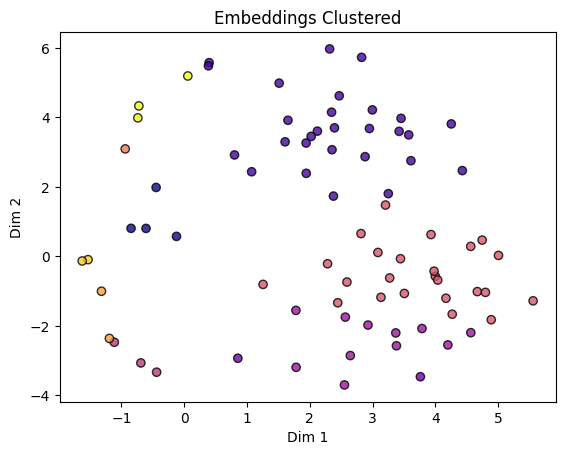

In [25]:

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_,    cmap='plasma', 
    edgecolor='k',   
    alpha=0.8       
)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Embeddings Clustered')
plt.show()

In [ ]:
closest = []
for i in range(10):
    distances = np.linalg.norm(embeddings_vectors - kmeans.cluster_centers_[i], axis=1)
    
    closest_index = np.argmin(distances)

    closest.append(closest_index)

In [ ]:
selected = sorted(closest)
selected

[np.int64(1),
 np.int64(8),
 np.int64(9),
 np.int64(11),
 np.int64(13),
 np.int64(22),
 np.int64(29),
 np.int64(59),
 np.int64(70),
 np.int64(78)]

In [ ]:
from langchain.schema import Document
from langchain.prompts import PromptTemplate

Test function

In [ ]:
map_prompt = """
Otrzymasz fragment książki. Ten fragment będzie zamknięty w potrójnych znakach odwrotnego apostrofu (```)
Twoim zadaniem jest stworzenie podsumowania tego fragmentu, tak aby czytelnik miał pełne zrozumienie tego, co się wydarzyło.
Twoja odpowiedź powinna mieć co najmniej trzy akapity i w pełni oddawać treść przedstawionego fragmentu.

```{text}```
PEŁNE PODSUMOWANIE:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])
def create_summmary(text):
    if len(chunked_text) < 2:
        prompt = f'Podsumuj tekst w jednym akapicie: {text}'
        response = llm(prompt)
        print(response)
    elif len(chunked_text) < 20: 
        summary_chain = load_summarize_chain(llm, chain_type='map_reduce')
        response = summary_chain.run(chunked_text)
        print(response)
    else:
        embeddings = OllamaEmbeddings(model="llama3.1:8b")
        embeddings_vectors = embeddings.embed_documents(chunked_text)
        n_clusters = 10
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings_vectors)
        closest = []
        for i in range(n_clusters):
            distances = np.linalg.norm(embeddings_vectors - kmeans.cluster_centers_[i], axis=1)
            
            closest_index = np.argmin(distances)

            closest.append(closest_index)
        selected = [int(x) for x in sorted(closest)]
        selected_docs = [chunked_text[doc] for doc in selected]
        summaries_list = []
        map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)
        for doc in selected_docs:
            chunk_summary = map_chain.run([doc])
            # Append that summary to your list
            summaries_list.append(chunk_summary) 
        summaries = "\n".join(summaries_list)
        summaries = Document(page_content=summaries)
        print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

In [ ]:
create_summmary(chunked_text)

/tmp/ipykernel_818/220557681.py:38: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  chunk_summary = map_chain.run([doc])


Your total summary has 7430 tokens
